In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('credit_score_cleaned_train.csv', low_memory=False)
raw.columns

Index(['id', 'customer_id', 'month', 'name', 'age', 'ssn', 'occupation',
       'annual_income', 'monthly_inhand_salary', 'credit_history_age',
       'total_emi_per_month', 'num_bank_accounts', 'num_credit_card',
       'interest_rate', 'num_of_loan', 'type_of_loan', 'delay_from_due_date',
       'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'payment_of_min_amount',
       'amount_invested_monthly', 'payment_behaviour', 'monthly_balance',
       'credit_score'],
      dtype='object')

In [3]:
raw = raw.dropna()
raw = raw.drop(['id', 'customer_id', 'name', 'ssn', 'type_of_loan'], axis='columns')
raw.dtypes

month                        object
age                           int64
occupation                   object
annual_income               float64
monthly_inhand_salary       float64
credit_history_age            int64
total_emi_per_month         float64
num_bank_accounts             int64
num_credit_card               int64
interest_rate                 int64
num_of_loan                   int64
delay_from_due_date           int64
num_of_delayed_payment        int64
changed_credit_limit        float64
num_credit_inquiries          int64
credit_mix                   object
outstanding_debt            float64
credit_utilization_ratio    float64
payment_of_min_amount        object
amount_invested_monthly     float64
payment_behaviour            object
monthly_balance             float64
credit_score                  int64
dtype: object

In [4]:
from itertools import chain

categorical = ['month', 'occupation', 'payment_behaviour']
ordinal = ['credit_mix', 'payment_of_min_amount']

for f in chain(categorical, ordinal):
    print(f'{f}: {*np.unique(raw[f]),}\n')

month: ('April', 'August', 'February', 'January', 'July', 'June', 'March', 'May')

occupation: ('Accountant', 'Architect', 'Developer', 'Doctor', 'Engineer', 'Entrepreneur', 'Journalist', 'Lawyer', 'Manager', 'Mechanic', 'Media_Manager', 'Musician', 'Scientist', 'Teacher', 'Writer')

payment_behaviour: ('High_spent_Large_value_payments', 'High_spent_Medium_value_payments', 'High_spent_Small_value_payments', 'Low_spent_Large_value_payments', 'Low_spent_Medium_value_payments', 'Low_spent_Small_value_payments')

credit_mix: ('Bad', 'Good', 'Standard')

payment_of_min_amount: ('No', 'Yes')



In [5]:
# Ignore categorical features
clean = raw.drop(categorical, axis='columns')

ordinal_encode = OrdinalEncoder(
    categories=[
        ['Bad', 'Standard', 'Good'],    # credit_mix
        ['No', 'Yes'],                  # payment_of_min_amount
    ]
)
clean[ordinal] = ordinal_encode.fit_transform(raw[ordinal])

In [6]:
def normalize(df : pd.DataFrame):
    scaler = MinMaxScaler()
    features = df[df.columns.drop(['credit_score', 'monthly_inhand_salary'])]
    target = df['credit_score']

    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2)

    # Normalize based only on the training data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print(f'{X_train.shape}  {X_test.shape}')
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = normalize(clean)

(77356, 18)  (19340, 18)


# Support Vector Machine Methodology

In [7]:
# instantiate classifier
svc=SVC()

# fit classifier to training set
svc.fit(X_train,Y_train)

# make predictions on test set
Y_pred = svc.predict(X_test)

              precision    recall  f1-score   support

           0       0.76      0.62      0.68      5481
           1       0.75      0.74      0.75     10268
           2       0.56      0.74      0.64      3591

    accuracy                           0.71     19340
   macro avg       0.69      0.70      0.69     19340
weighted avg       0.72      0.71      0.71     19340



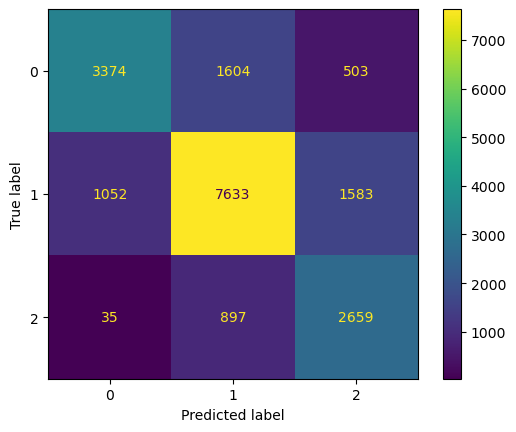

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# compute and print accuracy score
ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
print(classification_report(Y_test,Y_pred))

# Random Forest Methodology

In [9]:
model = RandomForestClassifier(n_estimators=100,random_state=7)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      5481
           1       0.83      0.81      0.82     10268
           2       0.77      0.77      0.77      3591

    accuracy                           0.81     19340
   macro avg       0.80      0.81      0.80     19340
weighted avg       0.81      0.81      0.81     19340



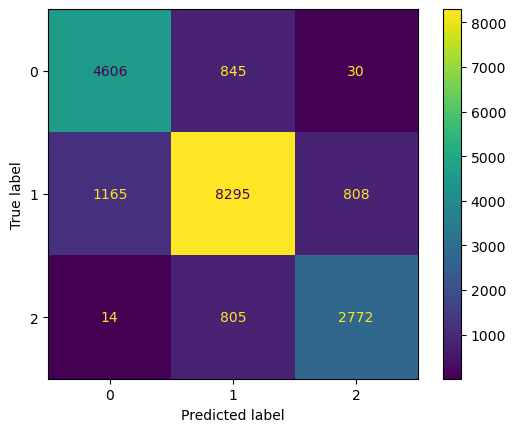

In [10]:
ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
print(classification_report(Y_test,Y_pred))

In [11]:
# # Feature importance for Mean Decrease GINI
# # Note: GINI importance is specific to decision trees and random forests
gini_importance = model.feature_importances_ * model.estimators_[0].tree_.impurity[0]
print(f"\nMean Decrease GINI= {gini_importance}")


Mean Decrease GINI= [0.02627892 0.02998173 0.04015356 0.03030748 0.01877254 0.02664727
 0.04834763 0.01853609 0.03898245 0.02579    0.03921392 0.02678804
 0.04953884 0.06867252 0.03349316 0.01148378 0.03419934 0.035028  ]


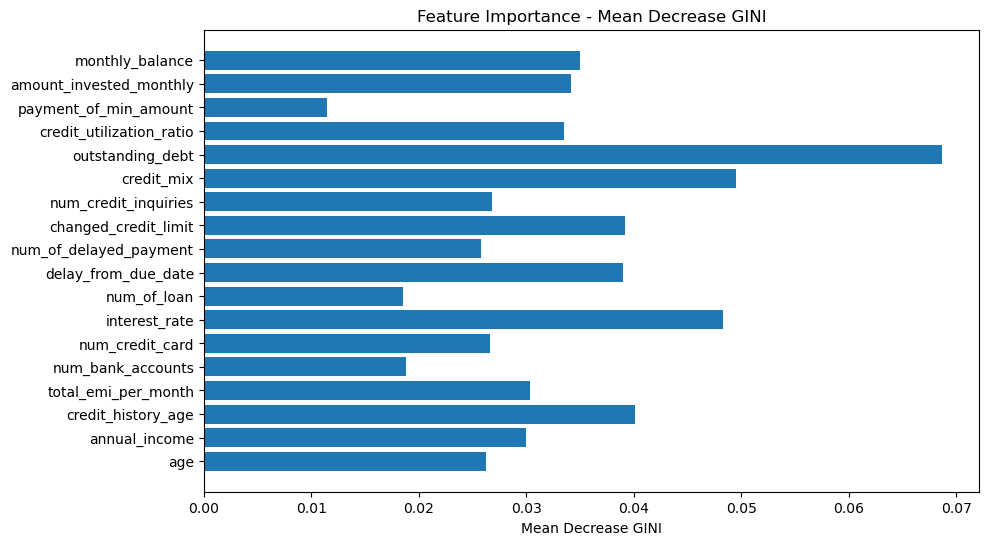

In [12]:
attr = clean[clean.columns.drop(['credit_score', 'monthly_inhand_salary'])]
plt.figure(figsize=(10, 6))
plt.barh(range(len(gini_importance)), gini_importance, align='center')
plt.yticks(range(len(gini_importance)), attr.columns)
plt.xlabel('Mean Decrease GINI')
plt.title('Feature Importance - Mean Decrease GINI')
plt.show()